In [3]:
# pip install rasterio
!pip install --upgrade rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 23.6 MB/s eta 0:00:00


In [5]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

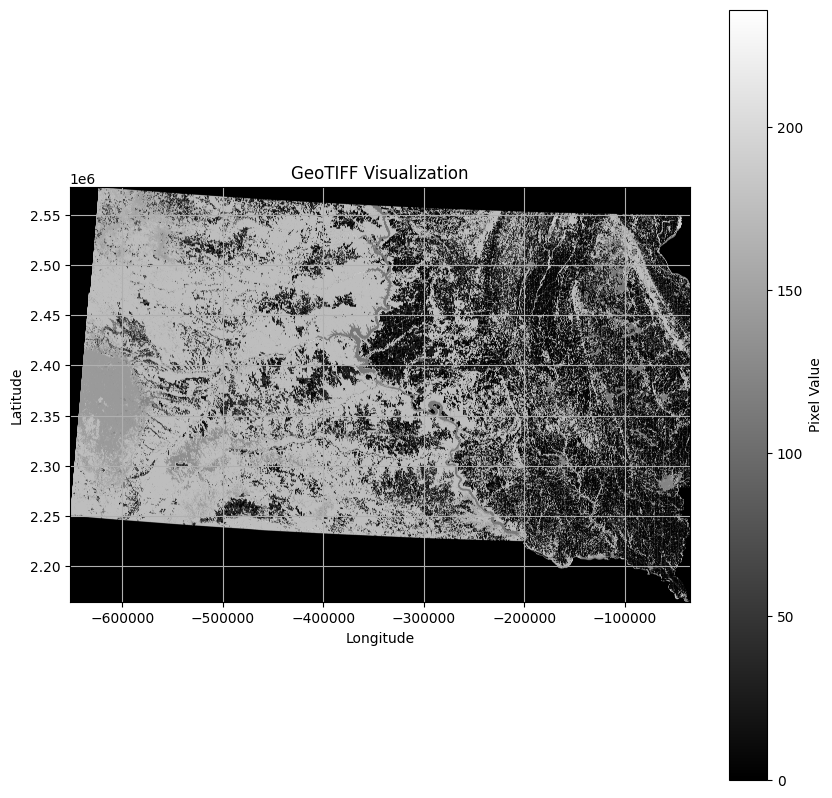

In [3]:
import rasterio
from matplotlib import pyplot as plt

# Open the GeoTIFF file
with rasterio.open('CDL_2023_46.tif') as src:
    # Read the raster data
    img = src.read(1)  # Assuming it's a single-band image, change the index if it's multiband
    # Get the spatial transformation
    transform = src.transform

# Visualize the raster data
plt.figure(figsize=(10, 10))
plt.imshow(img, extent=[transform[2], transform[2] + transform[0] * img.shape[1],
                        transform[5] + transform[4] * img.shape[0], transform[5]], cmap='gray')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('GeoTIFF Visualization')
plt.colorbar(label='Pixel Value')
plt.grid()
plt.show()


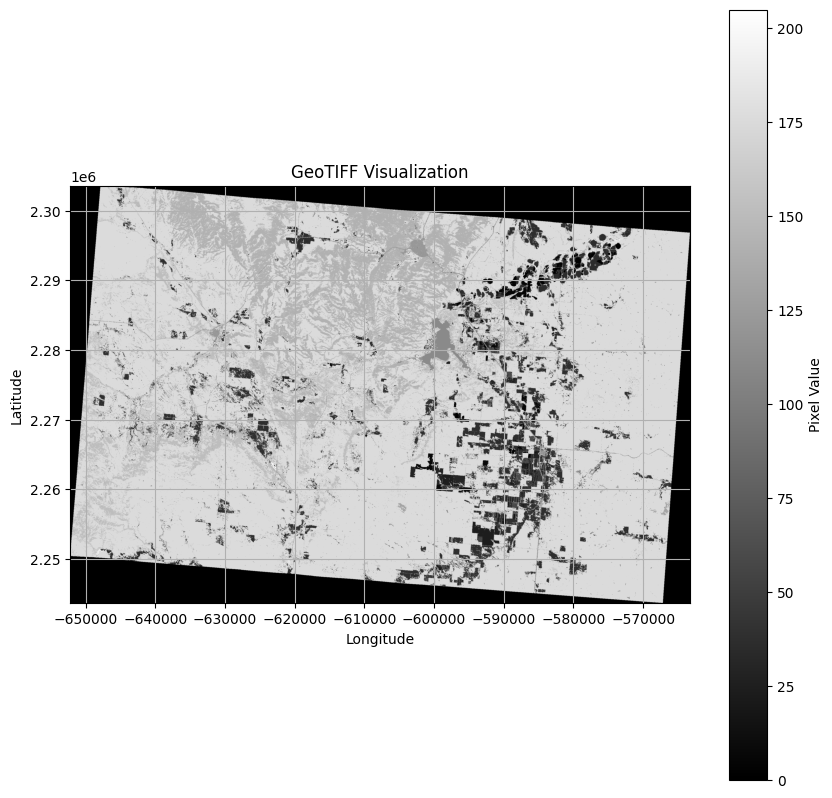

In [73]:
import rasterio
from matplotlib import pyplot as plt

# Open the GeoTIFF file
with rasterio.open('/content/masked_state_data_fr.tif') as src:
    # Read the raster data
    img = src.read(1)  # Assuming it's a single-band image, change the index if it's multiband
    # Get the spatial transformation
    transform = src.transform

# Visualize the raster data
plt.figure(figsize=(10, 10))
plt.imshow(img, extent=[transform[2], transform[2] + transform[0] * img.shape[1],
                        transform[5] + transform[4] * img.shape[0], transform[5]], cmap='gray')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('GeoTIFF Visualization')
plt.colorbar(label='Pixel Value')
plt.grid()
plt.show()


In [ ]:
import h5py
with h5py.File('crop_land.h5', 'w') as hf:
    hf.create_dataset('features', data=[])
    hf.create_dataset('target', data=[])
    hf.create_dataset('state_FIPS', data=[])
    hf.create_dataset('county_FIPS', data=[])

In [91]:
import geopandas as gpd
counties_gdf = gpd.read_file('/content/South_Dakota_County_Boundaries.geojson')

# Display the attribute table to see the available fields
print(counties_gdf.columns)


Index(['aland', 'countyfp', 'globalid', 'mtfcc', 'effectivedate',
       'target_geo_id2', 'geo', 'csafp', 'pop_hu', 'awater', 'pop_total',
       'funcstat', 'intptlat', 'lsad', 'id', 'cntyidfp', 'countyns', 'ur',
       'SHAPE__Area', 'pop_vac_hu', 'classfp', 'intptlon', 'metdivfp',
       'target_geo_id', 'pop_occ_hu', 'retireddate', 'statefp', 'intptlat10',
       'namelsad', 'intptlon10', 'id2', 'geoid', 'co_abbrev', 'name',
       'SHAPE__Length', 'cbsafp', 'objectid', 'geometry'],
      dtype='object')


In [6]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
from rasterio.crs import CRS

def generateNumpyFromTif(fileName, geoJson, stateFIPS):

  # Load the GeoTIFF file of the entire state
  with rasterio.open(fileName) as state_src:
      state_data = state_src.read(1)  # Read raster data
      state_meta = state_src.meta    # Get metadata
      print(state_meta)

      # Define the CRS of the state raster
      state_crs = CRS.from_epsg(5070)  # Assuming EPSG:5070

      # Load the shapefile containing county boundaries
      counties = gpd.read_file(geoJson)
      # Set CRS for county boundaries
      counties = counties.set_crs(epsg=4326, allow_override=True)
      # Reproject county boundaries to match the CRS of the state raster
      counties = counties.to_crs(state_crs)

      # Create an empty list to store masked datasets
      masked_datasets = []
      # Iterate over each county
      for i, county in counties.iterrows():
          # Convert the county boundary to GeoJSON format
          county_geojson = mapping(county['geometry'])
          try: # Mask the state data by the county boundary
            masked_data, masked_transform = mask(state_src, [county_geojson], crop=True)
            # Append the masked dataset to the list
            masked_datasets.append((masked_data[0], county['countyfp']))
          except:
            pass
  return masked_datasets

In [97]:
states = []
years = []
for year in years:
  for state in states:
    generateNumpyFromTif(fileName, geoJson, stateFIPS)

# Append new data to the HDF5 file
with h5py.File(h5_file, 'a') as hf:
    # Append new feature data
    hf['features'].resize((hf['features'].shape[0] + new_X.shape[0]), axis=0)
    hf['features'][-new_X.shape[0]:] = new_X

    # Append new target data
    hf['target'].resize((hf['target'].shape[0] + new_y.shape[0]), axis=0)
    hf['target'][-new_y.shape[0]:] = new_y

In [25]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
from rasterio.crs import CRS

# Load the GeoTIFF file of the entire state
with rasterio.open('/content/drive/MyDrive/MODIS_Surface_Temperature_Avg_Final/avg_surface_temp_Mar_to_May_2015.tif') as state_src:
    state_data = state_src.read(1)  # Read raster data
    state_meta = state_src.meta    # Get metadata
    print(state_meta)

    # Define the CRS of the state raster
    # state_crs = CRS.from_epsg(5070)  # Assuming EPSG:5070
    state_crs = CRS.from_epsg(4326)

    # Load the shapefile containing county boundaries
    counties = gpd.read_file('/content/South_Dakota_County_Boundaries.geojson')
    print(counties.columns)
    # Set CRS for county boundaries
    counties = counties.set_crs(epsg=4326, allow_override=True)
    # Reproject county boundaries to match the CRS of the state raster
    counties = counties.to_crs(state_crs)

    # Create an empty list to store masked datasets
    masked_datasets = []
    print(len(counties))
    # Iterate over each county
    for i, county in counties.iterrows():
        # Convert the county boundary to GeoJSON format
        county_geojson = mapping(county['geometry'])


        try: # Mask the state data by the county boundary
          masked_data, masked_transform = mask(state_src, [county_geojson], crop=True)

          # Append the masked dataset to the list
          masked_datasets.append((masked_data[0], county['countyfp']))

          # Update metadata with the transform of the last masked dataset
          # state_meta.update({
          #     'transform': masked_transform,
          #     'height': masked_data.shape[1],
          #     'width': masked_data.shape[2]
          # })
          # # print(masked_data.shape)
          # if county['name'].lower() == 'fall river':
          #   with rasterio.open('masked_state_data_fr.tif', 'w', **state_meta) as masked_src:
          #     masked_src.write(masked_data)
        except:
          pass

    # # Combine all masked datasets (optional)
    # combined_masked_data = sum([data[0] for data in masked_datasets])

    # # Write the masked data to a new GeoTIFF file
    # with rasterio.open('masked_state_data.tif', 'w', **state_meta) as masked_src:
    #     masked_src.write(combined_masked_data)
print(len(masked_datasets))

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 843, 'height': 395, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008983152841195215, 0.0, -104.05185935956418,
       0.0, -0.008983152841195215, 46.02069200544309)}


Index(['aland', 'countyfp', 'globalid', 'mtfcc', 'effectivedate',
       'target_geo_id2', 'geo', 'csafp', 'pop_hu', 'awater', 'pop_total',
       'funcstat', 'intptlat', 'lsad', 'id', 'cntyidfp', 'countyns', 'ur',
       'SHAPE__Area', 'pop_vac_hu', 'classfp', 'intptlon', 'metdivfp',
       'target_geo_id', 'pop_occ_hu', 'retireddate', 'statefp', 'intptlat10',
       'namelsad', 'intptlon10', 'id2', 'geoid', 'co_abbrev', 'name',
       'SHAPE__Length', 'cbsafp', 'objectid', 'geometry'],
      dtype='object')
66
66


In [86]:
masked_datasets[0][0]

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0, 111, 111, ...,   0,   0,   0],
       [  0, 111, 111, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

021 (40, 88)


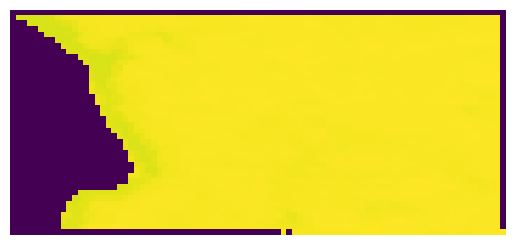

075 (82, 124)


005 (40, 70)


033 (46, 60)


071 (45, 99)


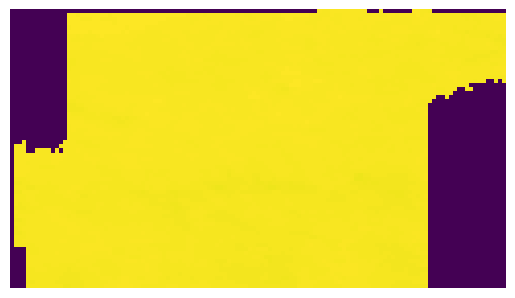

085 (72, 84)


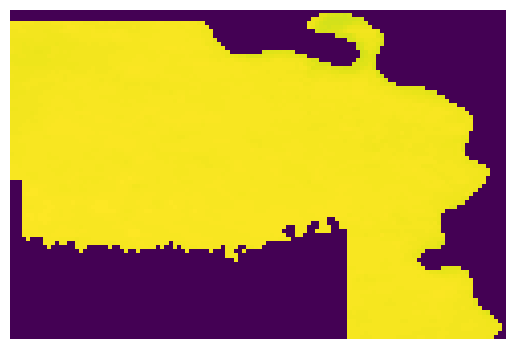

079 (45, 115)


013 (48, 54)


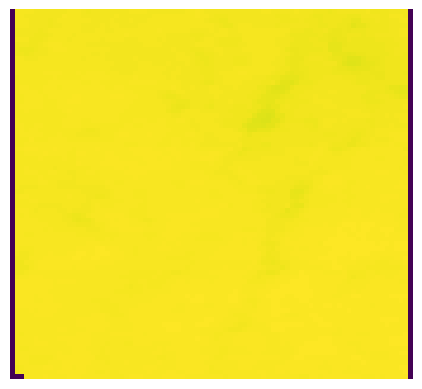

135 (40, 41)


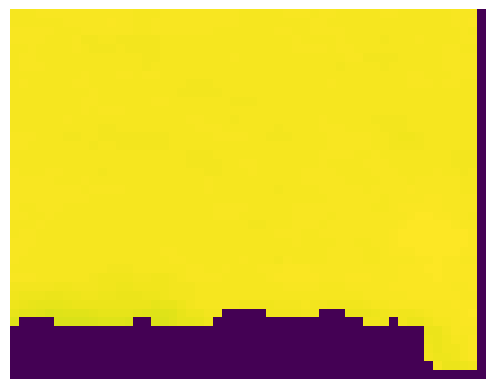

027 (70, 143)


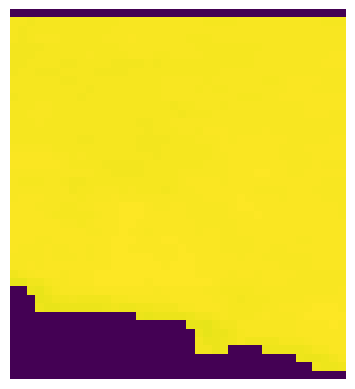

In [26]:
from matplotlib import pyplot as plt

for i in range(10):
  plt.imshow(masked_datasets[-i][0])
  print(masked_datasets[-i][1], masked_datasets[i][0].shape)
  plt.axis('off')  # Hide axis labels
  plt.show()